# Hybrid l1 and l2 sparse sampling of data elements

In [36]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
# This function calculates Xi for a single value in a matrix with an alpha value
@ np.vectorize
def xiijCalculate(Aij, AF2, A1, alpha):
  if Aij == 0:
    return 0
  numerator = AF2
  denominatorLeftTerm = (alpha * AF2) / (abs(Aij) * A1)
  denominatorRightTerm = 1 - alpha
  return numerator / (denominatorLeftTerm + denominatorRightTerm)

# This function calculates rho squared for a matrix and alpha value
def rho2Calculate(A, alpha):
  AF2 = np.linalg.norm(A, 'fro') ** 2
  A1 = np.linalg.norm(A, 1)
  xiMatrix = xiijCalculate(A, AF2, A1, alpha)
  iMax = np.sum(xiMatrix, 0).max()
  jMax = np.sum(xiMatrix, 1).max()
  max = np.maximum(iMax, jMax)
  minSingular = np.linalg.svd(A, compute_uv=False).min()
  return max - minSingular ** 2

# This function is a helper function for calculating gamma for a matrix and alpha
@ np.vectorize
def gammaInnerMax(Aij, AF2, A1, alpha):
  if Aij == 0:
    return 0
  denominator = alpha + (1 - alpha) * (A1 * abs(Aij) / AF2)
  return A1 / denominator

# This function calculates gamma for a matrix and alpha
def gammaCalculate(A, alpha):
  AF2 = np.linalg.norm(A, 'fro')
  A1 = np.linalg.norm(A, 1)
  max = gammaInnerMax(A, AF2, A1, alpha).max()
  return max + np.linalg.norm(A, 2)

# This calculates the function that needs to be minimized to find the optimal alpha
@ np.vectorize
def alphaFunction(alpha, A, epsilon):
  return rho2Calculate(A, alpha) + gammaCalculate(A, alpha) * epsilon * np.linalg.norm(A, 2) / 3

alphaFunction.excluded.add(1)


# This calculates the optimal alpha for a matrix
def alphaCalculate(A, epsilon):
  alphaOptions = np.linspace(epsilon, 1 - epsilon, 100)
  return alphaOptions[np.argmin(alphaFunction(alphaOptions, A, epsilon))]

# This calculates the optimal s for a matrix for a given alpha or the optimal alpha if none is given
def sCalculate(A, epsilon, delta, alpha=-1):
  A2 = np.linalg.norm(A, 2)
  firstCoefficient = 2 / ((epsilon ** 2) * (A2 ** 2))
  if(alpha <= 0 or alpha > 1):
    alpha = alphaCalculate(A, epsilon)
  secondCoefficient = alphaFunction(alpha, A, epsilon)
  n, m = A.shape
  thirdCoefficient = np.log((m + n) / delta)
  return int(np.ceil(firstCoefficient * secondCoefficient * thirdCoefficient))

# This calculates the hybrid probability for a value in matrix for a given alpha
@ np.vectorize
def pijCalculate(Aij, AF2, A1, alpha):
  return alpha * abs(Aij) / A1 + (1 - alpha) * (Aij ** 2) / AF2

# This is a helper function for sparsifying a matrix
def sumATilde(choice, ATilde, A, s, probabilities):
  i, j = np.unravel_index(choice, ATilde.shape)
  ATilde[i, j] += A[i, j] / probabilities[choice] / s

sumATilde = np.vectorize(sumATilde, excluded=['ATilde', 'A', 'probabilities'])

# Algorithm 1
# This function sparsifies a matrix using hybrid sparsification
def matrixSparsification(A, epsilon, delta, sMult=-1, alpha=-1):
  n, m = A.shape
  if alpha == -1:
    alpha = alphaCalculate(A, epsilon)
  if sMult == -1:
    s = sCalculate(A, epsilon, delta, alpha)
  else:
    k = round(np.linalg.norm(A, 'fro')**2/np.linalg.norm(A, 2)**2)
    s = sMult * k * (n + m)

  AF2 = np.linalg.norm(A, 'fro') ** 2
  A1 = np.linalg.norm(A, 1)
  probabilities = pijCalculate(A, AF2, A1, alpha).flatten()
  probabilities = probabilities / probabilities.sum()
  choices = np.random.choice(np.arange(n * m), s, p = probabilities)
  ATilde = np.zeros_like(A)
  sumATilde(choices, ATilde=ATilde, A=A, s=s, probabilities=probabilities)
  
  return ATilde, s, alpha

In [38]:
import torchvision

# needed to get the data in the right form
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnistTrain = torchvision.datasets.MNIST("./handdrawnDigits", train=True, download=True, transform=transform)
mnistTest = torchvision.datasets.MNIST("./handdrawnDigits", train=False, download=True, transform=transform)

digitsXtrain = np.array(mnistTrain.data)
digitsyTrain = np.array(mnistTrain.targets)
digitsXTest = np.array(mnistTest.data)
digitsyTest = np.array(mnistTest.targets)

### Hybrid Matrix Sparsification on MNIST Handwritten Digits 1, 6, and 9

In [39]:
data = digitsXtrain[np.logical_or(digitsyTrain == 1, np.logical_or(digitsyTrain == 6, digitsyTrain == 9))]

In [42]:
A = np.zeros((len(data), len(data[0].flatten())))
for i in range(len(data)):
  A[i] = data[i].flatten()/255

epsilon = 0.05
delta = 0.1

Errors = np.zeros((11, 3))
alphas = np.arange(0, 1.1, 0.1)
sMults = [1, 3, 5]
reps = 10

for rep in np.arange(reps):
  for alpha in alphas:
    for sMult in sMults:
      ATilde, s, alpha = matrixSparsification(A, epsilon, delta, sMult, alpha)

      Error = np.log2(np.linalg.norm(A - ATilde, 2) / np.linalg.norm(A, 2))
      Errors[int(alpha*10), int((sMult - 1) / 2)] += Error

      print("sMult: " + str(sMult) + "\nwith alpha: " + str(alpha) + "\nresults in log 2 error: " + str(Error))

Errors /= reps

sMult: 1
with alpha: 0.0
results in log 2 error: 0.08879575108826727
sMult: 3
with alpha: 0.0
results in log 2 error: 0.9817511091968628
sMult: 5
with alpha: 0.0
results in log 2 error: -0.7662418824285654
sMult: 1
with alpha: 0.1
results in log 2 error: -0.028408394997220327
sMult: 3
with alpha: 0.1
results in log 2 error: -0.8565641010908607
sMult: 5
with alpha: 0.1
results in log 2 error: -1.2005363546492158
sMult: 1
with alpha: 0.2
results in log 2 error: -0.056791649781348603
sMult: 3
with alpha: 0.2
results in log 2 error: -0.8649313207878624
sMult: 5
with alpha: 0.2
results in log 2 error: -1.2421651835885965
sMult: 1
with alpha: 0.30000000000000004
results in log 2 error: -0.020584150292067054
sMult: 3
with alpha: 0.30000000000000004
results in log 2 error: -0.8510048070499239
sMult: 5
with alpha: 0.30000000000000004
results in log 2 error: -1.2420101312131675
sMult: 1
with alpha: 0.4
results in log 2 error: -0.031119137649999407
sMult: 3
with alpha: 0.4
results in log 2 error:

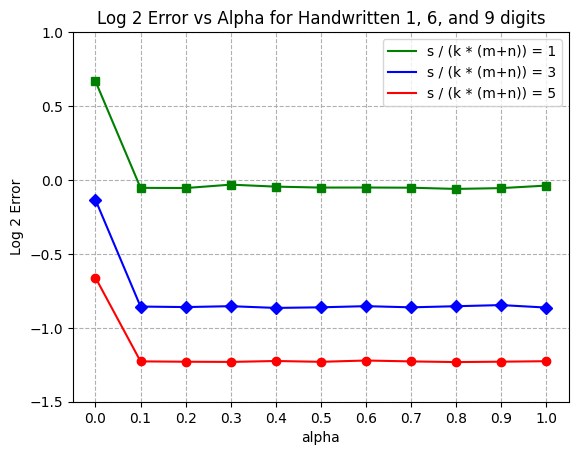

In [43]:
plt.plot(alphas, Errors[:,0], color='g')
plt.plot(alphas, Errors[:,1], color='b')
plt.plot(alphas, Errors[:,2], color='r')
plt.legend(["s / (k * (m+n)) = 1", "s / (k * (m+n)) = 3", "s / (k * (m+n)) = 5"])
plt.xticks(alphas)
max = np.ceil(Errors.max() * 2)/2
min = np.floor(Errors.min() * 2)/2
plt.yticks(np.arange(min, max+0.1, 0.5))
plt.grid(linestyle='--')
plt.gca().get_lines()[0].set_marker("s")
plt.gca().get_lines()[1].set_marker("D")
plt.gca().get_lines()[2].set_marker("o")
plt.xlabel("alpha")
plt.ylabel("Log 2 Error")
plt.title("Log 2 Error vs Alpha for Handwritten 1, 6, and 9 digits")
plt.show()

### Hybrid Matrix Sparsification on 2000 MNIST Handwritten Digits 1, 6, and 9

In [85]:
data = digitsXtrain[np.logical_or(digitsyTrain == 1, np.logical_or(digitsyTrain == 6, digitsyTrain == 9))]
data = data[np.random.choice(len(data), 2000)]

In [86]:
A = np.zeros((len(data), len(data[0].flatten())))
for i in range(len(data)):
  A[i] = data[i].flatten()/255

epsilon = 0.05
delta = 0.1

Errors = np.zeros((11, 3))
alphas = np.arange(0, 1.1, 0.1)
sMults = [1, 3, 5]
reps = 10

for rep in np.arange(reps):
  for alpha in alphas:
    for sMult in sMults:
      ATilde, s, alpha = matrixSparsification(A, epsilon, delta, sMult, alpha)

      Error = np.log2(np.linalg.norm(A - ATilde, 2) / np.linalg.norm(A, 2))
      Errors[int(alpha*10), int((sMult - 1) / 2)] += Error

      print("sMult: " + str(sMult) + "\nwith alpha: " + str(alpha) + "\nresults in log 2 error: " + str(Error))

Errors /= reps

sMult: 1
with alpha: 0.0
results in log 2 error: 0.3031121799451014
sMult: 3
with alpha: 0.0
results in log 2 error: 1.1437464309120418
sMult: 5
with alpha: 0.0
results in log 2 error: -0.14774060089393587
sMult: 1
with alpha: 0.1
results in log 2 error: -0.07812717638042306
sMult: 3
with alpha: 0.1
results in log 2 error: -0.9420607357421127
sMult: 5
with alpha: 0.1
results in log 2 error: -1.2979750152135718
sMult: 1
with alpha: 0.2
results in log 2 error: -0.06662656552313412
sMult: 3
with alpha: 0.2
results in log 2 error: -0.889073667337709
sMult: 5
with alpha: 0.2
results in log 2 error: -1.3065435652898727
sMult: 1
with alpha: 0.30000000000000004
results in log 2 error: -0.14159562579159032
sMult: 3
with alpha: 0.30000000000000004
results in log 2 error: -0.9735685984091405
sMult: 5
with alpha: 0.30000000000000004
results in log 2 error: -1.3479975653104075
sMult: 1
with alpha: 0.4
results in log 2 error: -0.009293154157225921
sMult: 3
with alpha: 0.4
results in log 2 error: -0.

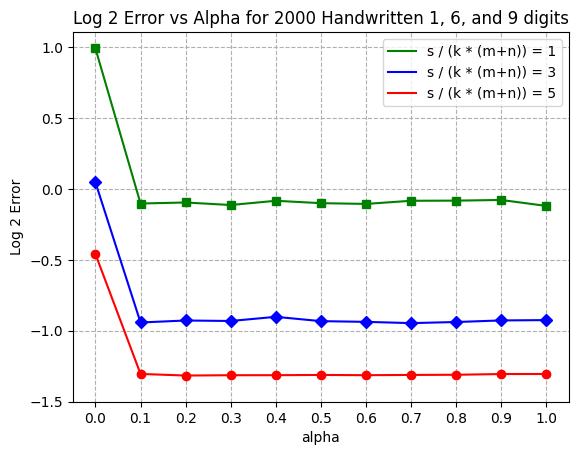

In [88]:
plt.plot(alphas, Errors[:,0], color='g')
plt.plot(alphas, Errors[:,1], color='b')
plt.plot(alphas, Errors[:,2], color='r')
plt.legend(["s / (k * (m+n)) = 1", "s / (k * (m+n)) = 3", "s / (k * (m+n)) = 5"])
plt.xticks(alphas)
max = np.ceil(Errors.max() * 2)/2
min = np.floor(Errors.min() * 2)/2
plt.yticks(np.arange(min, max+0.1, 0.5))
plt.grid(linestyle='--')
plt.gca().get_lines()[0].set_marker("s")
plt.gca().get_lines()[1].set_marker("D")
plt.gca().get_lines()[2].set_marker("o")
plt.xlabel("alpha")
plt.ylabel("Log 2 Error")
plt.title("Log 2 Error vs Alpha for 2000 Handwritten 1, 6, and 9 digits")
plt.show()

### Hybrid Matrix Sparsification on 2000 MNIST Handwritten Digits of all kinds

In [44]:
data = digitsXtrain[np.random.choice(len(digitsXtrain), 2000)]

In [45]:
A = np.zeros((len(data), len(data[0].flatten())))
for i in range(len(data)):
  A[i] = data[i].flatten()/255

epsilon = 0.05
delta = 0.1

Errors = np.zeros((11, 3))
alphas = np.arange(0, 1.1, 0.1)
sMults = [1, 3, 5]
reps = 10

for rep in np.arange(reps):
  for alpha in alphas:
    for sMult in sMults:
      ATilde, s, alpha = matrixSparsification(A, epsilon, delta, sMult, alpha)

      Error = np.log2(np.linalg.norm(A - ATilde, 2) / np.linalg.norm(A, 2))
      Errors[int(alpha*10), int((sMult - 1) / 2)] += Error

      print("sMult: " + str(sMult) + "\nwith alpha: " + str(alpha) + "\nresults in log 2 error: " + str(Error))

Errors /= reps

sMult: 1
with alpha: 0.0
results in log 2 error: 0.6736055954137814
sMult: 3
with alpha: 0.0
results in log 2 error: 0.9922020255206011
sMult: 5
with alpha: 0.0
results in log 2 error: -0.6983546673775599
sMult: 1
with alpha: 0.1
results in log 2 error: -0.14212967560633297
sMult: 3
with alpha: 0.1
results in log 2 error: -0.990442964276796
sMult: 5
with alpha: 0.1
results in log 2 error: -1.3644792011544122
sMult: 1
with alpha: 0.2
results in log 2 error: -0.1351756289619868
sMult: 3
with alpha: 0.2
results in log 2 error: -0.9894572925280589
sMult: 5
with alpha: 0.2
results in log 2 error: -1.360852219565474
sMult: 1
with alpha: 0.30000000000000004
results in log 2 error: -0.14141801531288717
sMult: 3
with alpha: 0.30000000000000004
results in log 2 error: -1.0111697822822876
sMult: 5
with alpha: 0.30000000000000004
results in log 2 error: -1.3318143932390398
sMult: 1
with alpha: 0.4
results in log 2 error: -0.05618422809020703
sMult: 3
with alpha: 0.4
results in log 2 error: -0.9720

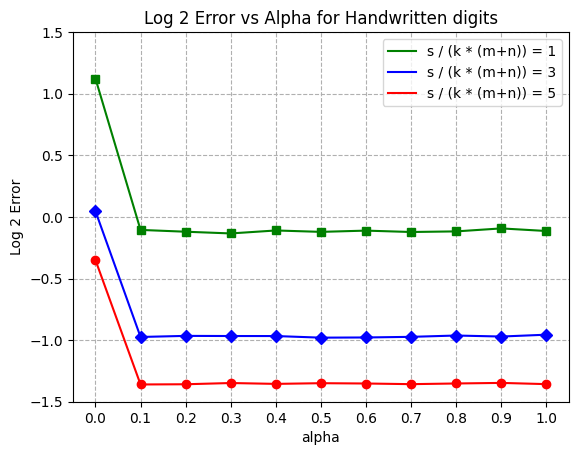

In [46]:
plt.plot(alphas, Errors[:,0], color='g')
plt.plot(alphas, Errors[:,1], color='b')
plt.plot(alphas, Errors[:,2], color='r')
plt.legend(["s / (k * (m+n)) = 1", "s / (k * (m+n)) = 3", "s / (k * (m+n)) = 5"])
plt.xticks(alphas)
max = np.ceil(Errors.max() * 2)/2
min = np.floor(Errors.min() * 2)/2
plt.yticks(np.arange(min, max+0.1, 0.5))
plt.grid(linestyle='--')
plt.gca().get_lines()[0].set_marker("s")
plt.gca().get_lines()[1].set_marker("D")
plt.gca().get_lines()[2].set_marker("o")
plt.xlabel("alpha")
plt.ylabel("Log 2 Error")
plt.title("Log 2 Error vs Alpha for Handwritten digits")
plt.show()

### Hybrid Matrix Sparsification on Football Scores

In [47]:
data = np.loadtxt(open("footballScores.csv", "rb"), delimiter=",")

In [48]:
A = data

epsilon = 0.05
delta = 0.1

Errors = np.zeros((11, 3))
alphas = np.arange(0, 1.1, 0.1)
sMults = [1, 3, 5]
reps = 10

for rep in np.arange(reps):
  for alpha in alphas:
    for sMult in sMults:
      ATilde, s, alpha = matrixSparsification(A, epsilon, delta, sMult, alpha)

      Error = np.log2(np.linalg.norm(A - ATilde, 2) / np.linalg.norm(A, 2))
      Errors[int(alpha*10), int((sMult - 1) / 2)] += Error

      print("sMult: " + str(sMult) + "\nwith alpha: " + str(alpha) + "\nresults in log 2 error: " + str(Error))

Errors /= reps

sMult: 1
with alpha: 0.0
results in log 2 error: 0.07963022665434542
sMult: 3
with alpha: 0.0
results in log 2 error: -0.7228993766043271
sMult: 5
with alpha: 0.0
results in log 2 error: -1.0868976780419242
sMult: 1
with alpha: 0.1
results in log 2 error: 0.029580496616212027
sMult: 3
with alpha: 0.1
results in log 2 error: -0.7695890102409265
sMult: 5
with alpha: 0.1
results in log 2 error: -1.1568825796667097
sMult: 1
with alpha: 0.2
results in log 2 error: -0.0061041246624298036
sMult: 3
with alpha: 0.2
results in log 2 error: -0.7998854637104547
sMult: 5
with alpha: 0.2
results in log 2 error: -1.168434381165708
sMult: 1
with alpha: 0.30000000000000004
results in log 2 error: -0.01910215134249206
sMult: 3
with alpha: 0.30000000000000004
results in log 2 error: -0.8025885696748153
sMult: 5
with alpha: 0.30000000000000004
results in log 2 error: -1.1811551928025148
sMult: 1
with alpha: 0.4
results in log 2 error: -0.049062298791135626
sMult: 3
with alpha: 0.4
results in log 2 error: 

In [49]:
Errors.shape

(11, 3)

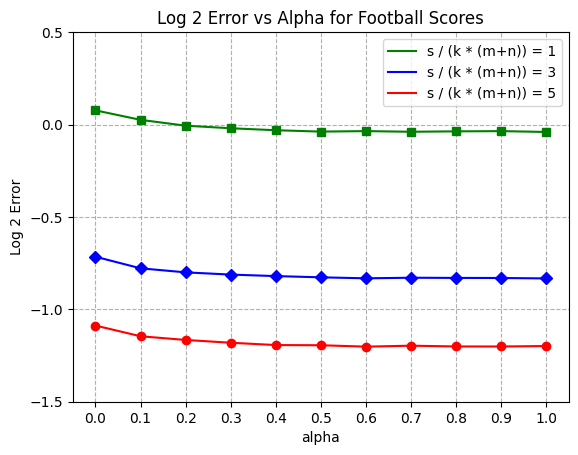

In [50]:
plt.plot(alphas, Errors[:,0], color='g')
plt.plot(alphas, Errors[:,1], color='b')
plt.plot(alphas, Errors[:,2], color='r')
plt.legend(["s / (k * (m+n)) = 1", "s / (k * (m+n)) = 3", "s / (k * (m+n)) = 5"])
plt.xticks(alphas)
max = np.ceil(Errors.max() * 2)/2
min = np.floor(Errors.min() * 2)/2
plt.yticks(np.arange(min, max+0.1, 0.5))
plt.grid(linestyle='--')
plt.gca().get_lines()[0].set_marker("s")
plt.gca().get_lines()[1].set_marker("D")
plt.gca().get_lines()[2].set_marker("o")
plt.xlabel("alpha")
plt.ylabel("Log 2 Error")
plt.title("Log 2 Error vs Alpha for Football Scores")
plt.show()

### Hybrid Matrix Sparsification on a Picture of a License Plate 1

In [68]:
import imageio.v3 as iio

data = iio.imread('licensePlates/Cars0.png')
data = data[:,:,0] + data[:,:,1] + data[:,:,2]
data.shape

(268, 500)

In [69]:
A = data

epsilon = 0.05
delta = 0.1

Errors = np.zeros((11, 3))
alphas = np.arange(0, 1.1, 0.1)
sMults = [1, 3, 5]
reps = 10

for rep in np.arange(reps):
  for alpha in alphas:
    for sMult in sMults:
      ATilde, s, alpha = matrixSparsification(A, epsilon, delta, sMult, alpha)

      Error = np.log2(np.linalg.norm(A - ATilde, 2) / np.linalg.norm(A, 2))
      Errors[int(alpha*10), int((sMult - 1) / 2)] += Error

      print("sMult: " + str(sMult) + "\nwith alpha: " + str(alpha) + "\nresults in log 2 error: " + str(Error))

Errors /= reps

sMult: 1
with alpha: 0.0
results in log 2 error: -0.004327951017423226
sMult: 3
with alpha: 0.0
results in log 2 error: -0.013023144102489283
sMult: 5
with alpha: 0.0
results in log 2 error: -0.023734132649770943
sMult: 1
with alpha: 0.1
results in log 2 error: -0.0029393694220373775
sMult: 3
with alpha: 0.1
results in log 2 error: -0.009172593425887726
sMult: 5
with alpha: 0.1
results in log 2 error: -0.011795795448171833
sMult: 1
with alpha: 0.2
results in log 2 error: -0.0020197091524229737
sMult: 3
with alpha: 0.2
results in log 2 error: -0.009928341753906502
sMult: 5
with alpha: 0.2
results in log 2 error: -0.01537577692114532
sMult: 1
with alpha: 0.30000000000000004
results in log 2 error: -0.0029466583684807906
sMult: 3
with alpha: 0.30000000000000004
results in log 2 error: -0.011030887496399723
sMult: 5
with alpha: 0.30000000000000004
results in log 2 error: -0.01727764523361763
sMult: 1
with alpha: 0.4
results in log 2 error: -0.002385916170583307
sMult: 3
with alpha: 0.4
res

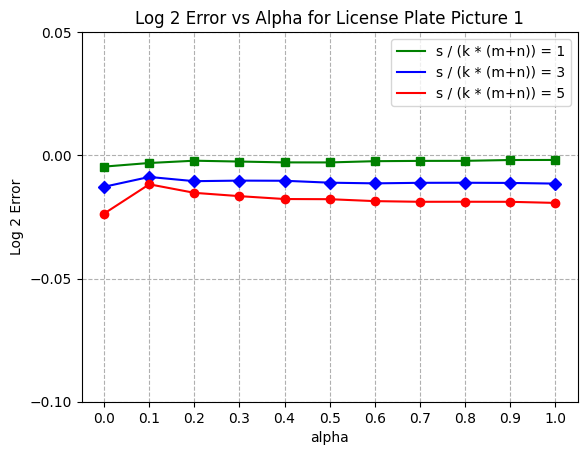

In [70]:
plt.plot(alphas, Errors[:,0], color='g')
plt.plot(alphas, Errors[:,1], color='b')
plt.plot(alphas, Errors[:,2], color='r')
plt.legend(["s / (k * (m+n)) = 1", "s / (k * (m+n)) = 3", "s / (k * (m+n)) = 5"])
plt.xticks(alphas)
max = np.ceil(Errors.max() * 10)/10
min = np.floor(Errors.min() * 10)/10
plt.yticks(np.arange(min, max+0.1, 0.05))
plt.grid(linestyle='--')
plt.gca().get_lines()[0].set_marker("s")
plt.gca().get_lines()[1].set_marker("D")
plt.gca().get_lines()[2].set_marker("o")
plt.xlabel("alpha")
plt.ylabel("Log 2 Error")
plt.title("Log 2 Error vs Alpha for License Plate Picture 1")
plt.show()

### Hybrid Matrix Sparsification on a Picture of a License Plate 2

In [76]:
import imageio.v3 as iio

data = iio.imread('licensePlates/Cars1.png')
data = data[:,:,0] + data[:,:,1] + data[:,:,2]
data.shape

(248, 400)

In [77]:
A = data

epsilon = 0.05
delta = 0.1

Errors = np.zeros((11, 3))
alphas = np.arange(0, 1.1, 0.1)
sMults = [1, 3, 5]
reps = 10

for rep in np.arange(reps):
  for alpha in alphas:
    for sMult in sMults:
      ATilde, s, alpha = matrixSparsification(A, epsilon, delta, sMult, alpha)

      Error = np.log2(np.linalg.norm(A - ATilde, 2) / np.linalg.norm(A, 2))
      Errors[int(alpha*10), int((sMult - 1) / 2)] += Error

      print("sMult: " + str(sMult) + "\nwith alpha: " + str(alpha) + "\nresults in log 2 error: " + str(Error))

Errors /= reps

sMult: 1
with alpha: 0.0
results in log 2 error: -0.004991751244734584
sMult: 3
with alpha: 0.0
results in log 2 error: -0.015767855755144684
sMult: 5
with alpha: 0.0
results in log 2 error: -0.026048226842416835
sMult: 1
with alpha: 0.1
results in log 2 error: -0.004121898952283484
sMult: 3
with alpha: 0.1
results in log 2 error: -0.007380002719619795
sMult: 5
with alpha: 0.1
results in log 2 error: -0.022857419046564867
sMult: 1
with alpha: 0.2
results in log 2 error: -0.002926746492693878
sMult: 3
with alpha: 0.2
results in log 2 error: -0.01053179942323461
sMult: 5
with alpha: 0.2
results in log 2 error: -0.022048206237788706
sMult: 1
with alpha: 0.30000000000000004
results in log 2 error: -0.0036266591674993915
sMult: 3
with alpha: 0.30000000000000004
results in log 2 error: -0.010930392201850497
sMult: 5
with alpha: 0.30000000000000004
results in log 2 error: -0.017862514693179704
sMult: 1
with alpha: 0.4
results in log 2 error: -0.0037641214125780764
sMult: 3
with alpha: 0.4
res

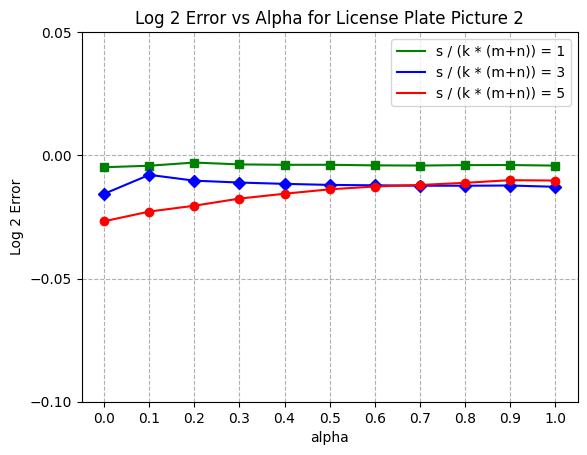

In [78]:
plt.plot(alphas, Errors[:,0], color='g')
plt.plot(alphas, Errors[:,1], color='b')
plt.plot(alphas, Errors[:,2], color='r')
plt.legend(["s / (k * (m+n)) = 1", "s / (k * (m+n)) = 3", "s / (k * (m+n)) = 5"])
plt.xticks(alphas)
max = np.ceil(Errors.max() * 10)/10
min = np.floor(Errors.min() * 10)/10
plt.yticks(np.arange(min, max+0.1, 0.05))
plt.grid(linestyle='--')
plt.gca().get_lines()[0].set_marker("s")
plt.gca().get_lines()[1].set_marker("D")
plt.gca().get_lines()[2].set_marker("o")
plt.xlabel("alpha")
plt.ylabel("Log 2 Error")
plt.title("Log 2 Error vs Alpha for License Plate Picture 2")
plt.show()

### Hybrid Matrix Sparsification on a Picture of a License Plate 3

In [79]:
import imageio.v3 as iio

data = iio.imread('licensePlates/Cars2.png')
data = data[:,:,0] + data[:,:,1] + data[:,:,2]
data.shape

(400, 400)

In [80]:
A = data

epsilon = 0.05
delta = 0.1

Errors = np.zeros((11, 3))
alphas = np.arange(0, 1.1, 0.1)
sMults = [1, 3, 5]
reps = 10

for rep in np.arange(reps):
  for alpha in alphas:
    for sMult in sMults:
      ATilde, s, alpha = matrixSparsification(A, epsilon, delta, sMult, alpha)

      Error = np.log2(np.linalg.norm(A - ATilde, 2) / np.linalg.norm(A, 2))
      Errors[int(alpha*10), int((sMult - 1) / 2)] += Error

      print("sMult: " + str(sMult) + "\nwith alpha: " + str(alpha) + "\nresults in log 2 error: " + str(Error))

Errors /= reps

sMult: 1
with alpha: 0.0
results in log 2 error: -0.003800786931042383
sMult: 3
with alpha: 0.0
results in log 2 error: -0.010306376585031933
sMult: 5
with alpha: 0.0
results in log 2 error: -0.01723929491833192
sMult: 1
with alpha: 0.1
results in log 2 error: -0.00271361269863526
sMult: 3
with alpha: 0.1
results in log 2 error: -0.007942257571151173
sMult: 5
with alpha: 0.1
results in log 2 error: -0.01652477298267153
sMult: 1
with alpha: 0.2
results in log 2 error: -0.0026631574516143897
sMult: 3
with alpha: 0.2
results in log 2 error: -0.004782569896879379
sMult: 5
with alpha: 0.2
results in log 2 error: -0.014905091207218233
sMult: 1
with alpha: 0.30000000000000004
results in log 2 error: -0.002940239562665595
sMult: 3
with alpha: 0.30000000000000004
results in log 2 error: -0.00642891716241316
sMult: 5
with alpha: 0.30000000000000004
results in log 2 error: -0.010901682442078543
sMult: 1
with alpha: 0.4
results in log 2 error: -0.0017612538839607242
sMult: 3
with alpha: 0.4
result

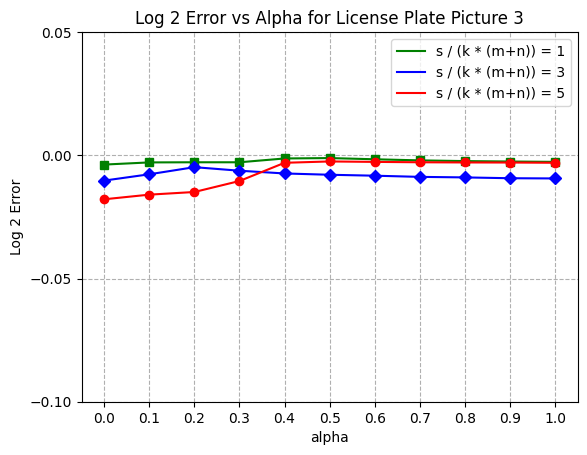

In [81]:
plt.plot(alphas, Errors[:,0], color='g')
plt.plot(alphas, Errors[:,1], color='b')
plt.plot(alphas, Errors[:,2], color='r')
plt.legend(["s / (k * (m+n)) = 1", "s / (k * (m+n)) = 3", "s / (k * (m+n)) = 5"])
plt.xticks(alphas)
max = np.ceil(Errors.max() * 10)/10
min = np.floor(Errors.min() * 10)/10
plt.yticks(np.arange(min, max+0.1, 0.05))
plt.grid(linestyle='--')
plt.gca().get_lines()[0].set_marker("s")
plt.gca().get_lines()[1].set_marker("D")
plt.gca().get_lines()[2].set_marker("o")
plt.xlabel("alpha")
plt.ylabel("Log 2 Error")
plt.title("Log 2 Error vs Alpha for License Plate Picture 3")
plt.show()

### Hybrid Matrix Sparsification on a Picture of a License Plate 4

In [82]:
import imageio.v3 as iio

data = iio.imread('licensePlates/Cars3.png')
data = data[:,:,0] + data[:,:,1] + data[:,:,2]
data.shape

(225, 400)

In [83]:
A = data

epsilon = 0.05
delta = 0.1

Errors = np.zeros((11, 3))
alphas = np.arange(0, 1.1, 0.1)
sMults = [1, 3, 5]
reps = 10

for rep in np.arange(reps):
  for alpha in alphas:
    for sMult in sMults:
      ATilde, s, alpha = matrixSparsification(A, epsilon, delta, sMult, alpha)

      Error = np.log2(np.linalg.norm(A - ATilde, 2) / np.linalg.norm(A, 2))
      Errors[int(alpha*10), int((sMult - 1) / 2)] += Error

      print("sMult: " + str(sMult) + "\nwith alpha: " + str(alpha) + "\nresults in log 2 error: " + str(Error))

Errors /= reps

sMult: 1
with alpha: 0.0
results in log 2 error: -0.005223606005320228
sMult: 3
with alpha: 0.0
results in log 2 error: -0.01766757324164204
sMult: 5
with alpha: 0.0
results in log 2 error: -0.02544318764539085
sMult: 1
with alpha: 0.1
results in log 2 error: -0.004134989077361805
sMult: 3
with alpha: 0.1
results in log 2 error: -0.014002503414690804
sMult: 5
with alpha: 0.1
results in log 2 error: -0.01785080971778914
sMult: 1
with alpha: 0.2
results in log 2 error: -0.0035429237159139435
sMult: 3
with alpha: 0.2
results in log 2 error: -0.014417115276733668
sMult: 5
with alpha: 0.2
results in log 2 error: -0.023013132202532163
sMult: 1
with alpha: 0.30000000000000004
results in log 2 error: -0.001988265516102008
sMult: 3
with alpha: 0.30000000000000004
results in log 2 error: -0.013696746421530176
sMult: 5
with alpha: 0.30000000000000004
results in log 2 error: -0.024586028261750208
sMult: 1
with alpha: 0.4
results in log 2 error: -0.003119079475449686
sMult: 3
with alpha: 0.4
result

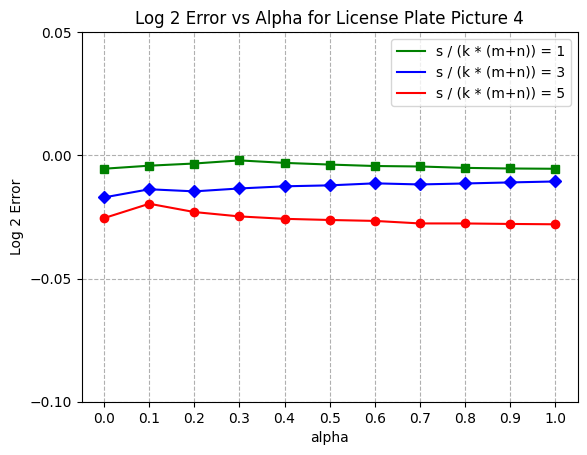

In [84]:
plt.plot(alphas, Errors[:,0], color='g')
plt.plot(alphas, Errors[:,1], color='b')
plt.plot(alphas, Errors[:,2], color='r')
plt.legend(["s / (k * (m+n)) = 1", "s / (k * (m+n)) = 3", "s / (k * (m+n)) = 5"])
plt.xticks(alphas)
max = np.ceil(Errors.max() * 10)/10
min = np.floor(Errors.min() * 10)/10
plt.yticks(np.arange(min, max+0.1, 0.05))
plt.grid(linestyle='--')
plt.gca().get_lines()[0].set_marker("s")
plt.gca().get_lines()[1].set_marker("D")
plt.gca().get_lines()[2].set_marker("o")
plt.xlabel("alpha")
plt.ylabel("Log 2 Error")
plt.title("Log 2 Error vs Alpha for License Plate Picture 4")
plt.show()